### You can modify the pathes in cell 11 to get one csv file, which is the summarization of the usage of sensors, and two pkl files which contains the names of the apps using variables instead integer.

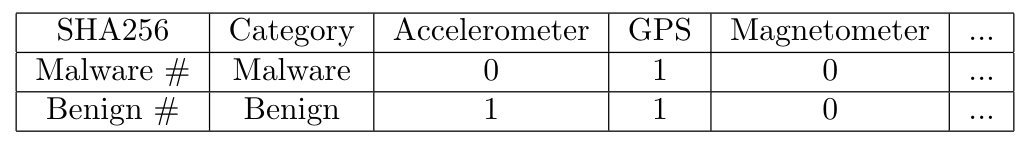

In [1]:
# The csv file you can get from this notebook 

from PIL import Image 

img = Image.open('sample_form-1.png') 
img

In [2]:
import os
import io
from os import listdir
from os.path import isfile, join
import pickle

import pandas as pd

In [3]:
# Integer and Sensor Pairs Listed in The Documentation
int_sensor = {1: 'accelerometer', 35: 'accelerometer_uncalibrated', -1: 'all', 
              13: 'ambient_temperature', 65536: 'device_private_base', 15: 'game_rotation_vector', 
              20: 'geomagnetic_rotation_vector', 9: 'gravity', 4: 'gyroscope', 16: 'gyroscope_uncalibrated', 
              31: 'heart_beat', 21: 'heart_rate', 36: 'hinge_angle', 5: 'light', 10: 'linear_acceleration', 
              34: 'low_latency_offbody_detect', 2: 'magnetic_field', 14: 'magnetic_field_uncalibrated', 
              30: 'motion_detect', 3: 'orientation', 28: 'pose_6dof', 6: 'pressure', 8: 'proximity', 
              12: 'relative_humidity', 11: 'rotation_vector', 17: 'significant_motion', 29: 'stationary_detect', 
              19: 'step_counter', 18: 'step_detector', 7: 'temperature'}

In [4]:
def get_sensor_info(path, dic, var_file):
    lst = listdir(path)  # Get all the apps (directory)
    lst = [f for f in lst if f != '.DS_Store']  # Remove '.DS_Store'
    
    cnt = 1
    for folder in lst:
        print('APK', cnt, folder)
        dic[folder] = {}
        for i in int_sensor.keys():  # Initialize dic, set the value of each sensor to be 0.
            dic[folder][i] = 0
        path_apk = os.path.join(path, '%s' % (folder))
        activity_service_paths = search_AndroidManifes(path_apk)  # Get the paths of all the activities' and services' java file.
        
        for p in activity_service_paths:  # For each activity or service
            p = os.path.join(path_apk, 'sources/%s.java' % (p))
            import_classes_paths, package_classes_paths = searchin_Activity_Service(p, path_apk)  # Get the paths of all the classes used in the java files of the activity or service.

            for c_path in import_classes_paths:  # For each valid java file, get its sensor usage.
                c_path = os.path.join(path_apk, 'sources/%s.java' % (c_path))
                dic, var_file = search(c_path, folder, dic, var_file)
          
            for c_path in package_classes_paths:
                dic, var_file = search(c_path, folder, dic, var_file)
        cnt += 1
    return dic

In [5]:
# Get all the "activity" and "service" from AndroidManifest.xml
def search_AndroidManifes(path):
    '''Return the paths of all the activities' and services' java file.'''
    path = os.path.join(path, 'resources/AndroidManifest.xml')
    activity_service_paths = []
    with open(path, 'r') as filehandle:
        for line in filehandle:
            if '<activity' in line or '<service' in line:
                try:
                    activity_service_paths.append(line.split('android:name="')[1].split('"')[0].strip('.').replace('.', '/'))
                except IndexError:
                    activity_service_paths.append(line.split('ns0:name="')[1].split('"')[0].strip('.').replace('.', '/'))
                    
    return activity_service_paths

In [6]:
# Get all the classes imported in an "activity" or "service".
def searchin_Activity_Service(p1, p2):  # p1: the path of the activity or service; p2: the path of the main directory, e.g. Repack_Apk/, Original_APK/
    '''Return the paths of all the classes used in the java files of the activity or service.'''
    valid_i_classes = []
    valid_i_classes_paths = []
    valid_p_classes = []
    valid_p_classes_paths = []
    import_classes = []
    import_classes_paths = []
    package_classes = []
    package_classes_paths = []
    p_classes = []
    p_classes_paths = []
    
    def package_files(f, path, package_classes, package_classes_paths):
        '''Go into a directory and find all the java files in that folder until there's no directory any more.'''
        if '.java' in f:  # If a file is a java file, then call search() method to get sensor information.
            package_classes.append(f.split('.')[0])
            package_classes_paths.append(os.path.join(path, '%s' % (f)))
        elif '.' not in f:  # If it's a directory, then call java_file() for each file or directory inside it.
            files = listdir(os.path.join(path, '%s' % (f)))
            for file in files:
                package_files(file, os.path.join(path, '%s' % (f)), package_classes, package_classes_paths)
    
    try:
        with open(p1, 'r') as filehandle:
            for line in filehandle:
                if 'import' in line:
                    import_classes.append(line.strip(';\n').split(' ')[1].split('.')[-1])
                    import_classes_paths.append(line.strip(';\n').split(' ')[1].replace('.', '/'))
                elif 'package' in line:
                    package_folder_path = os.path.join(p2, 'sources', line.strip(';\n').split(' ')[1].replace('.', '/'))
                    files = listdir(package_folder_path)
                    for f in files:
                        package_files(f, package_folder_path, p_classes, p_classes_paths)
                    package_classes.extend(package_classes)
                    package_classes_paths.extend(package_classes_paths)
                    p_classes = []
                    p_classes_paths = []
                else:
                    for i in range(len(import_classes)):
                        if import_classes[i] in line and import_classes_paths[i] not in valid_i_classes_paths:
                            valid_i_classes.append(import_classes[i])
                            valid_i_classes_paths.append(import_classes_paths[i])  
                    for i in range(len(package_classes)):    
                        if package_classes[i] in line and package_classes_paths[i] not in valid_p_classes_paths:
                            valid_p_classes.append(package_classes[i])
                            valid_p_classes_paths.append(package_classes_paths[i])
    
    except FileNotFoundError:
        pass
    
    if p1 not in valid_p_classes_paths:
        valid_p_classes.append(p1.split('/')[-1].split('.')[0])
        valid_p_classes_paths.append(p1)
 
    return valid_i_classes_paths, valid_p_classes_paths 

In [7]:
def search(code, apk, dic, var_file):
    '''Search sensor information in a java file. Only search getDefaultSensor() and getSensorList() methods.'''    
    # Open the file. Sometimes it pops out an "UnicodeDecodeError" error, so we need to use another method when this happens.
    try: 
        with open(code, 'r') as filehandle:
            for line in filehandle:
                line = line.split('//')[0]  # Remove comments
                if 'getDefaultSensor(' in line:  # Search getDefaultSensor()
                    sensor = line.split('getDefaultSensor(')[1].split(')')[0]  # Get the integer inside getDefaultSensor()
                    if sensor.isnumeric() or sensor == '-1':  # If it's an integer, set value of the corresponding sensor to be 1 which means this app uses this sensor.
                        if dic[apk].get(int(sensor)) == 0:
                            dic[apk][int(sensor)] = 1
                    else:  # If it's not an integer but a variable, then record the file under the apk.
                        if apk not in var_file.keys():
                            var_file[apk] = [code]
                        else:
                            var_file[apk].append(code)
                if 'getSensorList(' in line:    # Search getSensorList()
                    sensor = line.split('getSensorList(')[1].split(')')[0]  # Get the integer inside getSensorList()
                    if sensor.isnumeric() or sensor == '-1':  # If it's an integer, set value of the corresponding sensor to be 1 which means this app uses this sensor.
                        if dic[apk].get(int(sensor)) == 0:
                            dic[apk][int(sensor)] = 1
                    else:  # If it's not an integer but a variable, then record the file under the apk.
                        if apk not in var_file.keys():
                            var_file[apk] = [code]
                        else:
                            var_file[apk].append(code)
    except UnicodeDecodeError:
        with io.open(code, 'r', encoding='windows-1252') as filehandle:
            for line in filehandle:
                line = line.split('//')[0]  # Remove comments
                if 'getDefaultSensor(' in line:  # The same as the above. 
                    sensor = line.split('getDefaultSensor(')[1].split(')')[0]
                    if sensor.isnumeric() or sensor == '-1':
                        if dic[apk].get(int(sensor)) == 0:
                            dic[apk][int(sensor)] = 1
                    else:
                        if apk not in var_file.keys():
                            var_file[apk] = [code]
                        else:
                            var_file[apk].append(code)
                if 'getSensorList(' in line:
                    sensor = line.split('getSensorList(')[1].split(')')[0]
                    if sensor.isnumeric() or sensor == '-1':
                        if dic[apk].get(int(sensor)) == 0:
                            dic[apk][int(sensor)] = 1
                    else:
                        if apk not in var_file.keys():
                            var_file[apk] = [code]
                        else:
                            var_file[apk].append(code)
                        
    
    except FileNotFoundError:
        pass
    
    return dic, var_file

In [8]:
def get_paramInt_info(dic, var_file):
    '''Get the usage of sensors involving variables.'''
    for key, val in var_file.items():  # key: name of apk file, val: the paths of the java files where paramInt is used.
        for v in val:  # v: the path of one java file where paramInt is used.
            with open(v, 'r') as filehandle:
                java = []
                for line in filehandle:  # Save the java code to a lst, which is done for convenience.
                    java.append(line)
                methods = []  # Used to store the functions where paramInt is used.
                positions = []  # Used to store the position of paramInt among all the parameters of the method.
                for i in range(len(java)):
                    line = java[i].split('//')[0]  # Remove comments
                
                    if i < len(java)-1 and 'getSensorList(' in java[i+1]:  # Get the name of the method which using getSensorList(paramInt)
                        methods.append(line.strip(' ').split(' ')[2].split('(')[0])
                        parameters = line.strip(' ').split('(')[1].split(')')[0].split(',')
                        for i in range(len(parameters)):
                            if 'paramInt' in parameters[i]:
                                positions.append(i)
            dic = get_paramInt_val(dic, key, v, methods, positions)  # Get the integer that paramInt represents.
        
    return dic

In [9]:
def get_paramInt_val(dic, apk, path, methods, positions):
    '''Get the integer that paramInt represents.'''
    with open(path, 'r') as filehandle:
        for line in filehandle:
            for i in range(len(methods)):
                if methods[i] + '(' in line:  # If the line contains the name of the method, then
                    params = line.strip(' ').split('%s(' % (methods[i]))[1].split(')')[0].split(',')  # Get the parameters this method takes
                    if params[positions[i]].strip(' ').isnumeric() or params[positions[i]].strip(' ') == '-1':  # If the parameter which corresponds to paramInt is an integer, then extract it and record. 
                        if dic[apk].get(int(params[positions[i]].strip(' '))) == 0: 
                            dic[apk][int(params[positions[i]].strip(' '))] = 1
                    
    return dic

In [10]:
# Create the dataframe
columns_1 = ['SHA256', 'Category']
columns_2 = int_sensor.keys()

df1 = pd.DataFrame(columns = columns_1)
df2 = pd.DataFrame(columns = columns_2)

In [11]:
'''Main Part!!!'''

'''Get repackaged apps' sensor info'''
path = 'Repack_APK/'
dic = {}  # A dictionary used to record whether or not this app uses each sensor.
var_file = {}  # A dictionary used to record the files which involving variables in getDefaultSensor() or getSensorList() method.
dic = get_sensor_info(path, dic, var_file)
if var_file:
    dic = get_paramInt_info(dic, var_file)
    
for key, val in dic.items():
    df1 = df1.append({'SHA256': key, 'Category': 'Malware'}, ignore_index = True)
    df2 = df2.append(val, ignore_index = True)

with open('Repack_Variable_Apps.pkl', 'wb') as f:  # Save the names of the repackaged apps which use variables.
    pickle.dump(var_file, f)

print('Repackaged Apps Done!')    
    
    
'''Get original apps' sensor info'''
path = '/Volumes/SeagateExp/Original/'
dic = {}  # A dictionary used to record whether or not this app uses each sensor.
var_file = {}  # # A dictionary used to record the files which involving variables in getDefaultSensor() or getSensorList() method.
dic = get_sensor_info(path, dic, var_file)
if var_file:
    dic = get_paramInt_info(dic, var_file)
    
for key, val in dic.items():
    df1 = df1.append({'SHA256': key, 'Category': 'Benign'}, ignore_index = True)
    df2 = df2.append(val, ignore_index = True)
    
with open('Original_Variable_Apps.pkl', 'wb') as f:  # Save the names of the original apps which use variables.
    pickle.dump(var_file, f)

print('Original Apps Done!')      
    
    
'''Combine repackaged apps' sensor info with original apps' sensor info and save it to a csv file'''
df2 = df2.apply(lambda row: row + 1 if row[-1] == 1 else row, axis = 1)
df2 = df2.replace({2: 1})
df2.columns = int_sensor.values()
df2.drop(['all'], axis = 1, inplace = True)

# Join df1 and df2
df = df1.join(df2)

df.to_csv('Sensor_Usage_v2.csv', index = False)

APK 1 6CD0F61EF4116065590F584B2AED895BFBAB4F20493101E7ACCC121C33D63433
APK 2 444047B4B012A13B9E612D20D916A84A64F481FF194BBD0AA9D87DA58DF2735A
APK 3 EA5FBEE77ACF14C5E3328531E87590C177F855D89552F424836D6244361AFCB2
APK 4 2776F89AC4C6D195A66C6D265C18B99B7A161DD0FA07727B4380210E966A8D26
APK 5 6EAA1827DF3A561A54542AE99072284D373AD49CADEF4C0014156856B373E530
APK 6 74C2B1F7DC7A7CD81612370E8F8D69696B10CAF585F2B74CA2837A5B8F33D84E
APK 7 E7FC347AD3F6F90E2CCABBEA56DE3D3A718A01A7E1AC959714A1DCA5E3AFD9CA
APK 8 D5558431DC2300967564F701F3EF72623E3667F51390D6832F31C37CD730DD43
APK 9 C44425EC781CAFCBF79ABA20654F3BE8C2166368CA5B76AB3D013B1853D564BC
APK 10 382783DFC70EA7742CF1399B72962D18C85D88B08FCE25CDFC5D66E95F34EFB4
APK 11 7C4F286117947FDCE1662E13BEA2F971A9F618197D7AEC88DB79256E01379158
APK 12 779F4ADE92164A1D5ACD24CA867436079B5966F0EE78DF9BCFAD5286CB9838C5
APK 13 C0347C31037981C85F50916EC22763DB09964C3FF5B0F7641188D0C846FDBD77
APK 14 8B52C78F61770F04E6C639FC4D8D373D787C3DDA8EF866EBE073B4F48DDBE1CB
A

APK 116 75523363D8D0F7E9B052C73318B93EAF17BF21C08293C9094FB1141FD41C0451
APK 117 784A9101801C166D94EC31386CC3DE645340D30D4278D4D97EFF951E4EFCBEB1
APK 118 FA790073731294B36CA893CCFBB1E08A656B1B5AB67565CDA5B695146A30B988
APK 119 9326C720900B04D8EAA5B19E1AA1D12266E6481A9768DA256B7F7016A15FD554
APK 120 5AA0B57221215B0B75DD9E106E8320C6E90D61A2E8A3E17F844397AF4940EE9D
APK 121 4D556BB24342CF77DEE35557878D298D41C9ECFC7BE243F59BCB9EE91A072D4E
APK 122 92E6DED8C0617135FE1F209E838DE548A1C4D28F5526BC116934AD7B3042F865
APK 123 C6F05A060B3572E5EBE341CC87324DF2AACA50E2908E64CD96ED34BFEE9DCAD2
APK 124 AC19D1AE8F26EA3F8B97E07C14CAA0A4AD0D51AEE2FB48F719BB26D8FD59B5E2
APK 125 A690E62AC339DCD9A2452BDC34F496B0565BB3FBB01F739755392E7AF742CC70
APK 126 2547563EAA55AC1B3AC1EE9AA36F271DBF85AAD5D26A18C7511C162542F6ADFB
APK 127 686A6AA0B32BFFE911E13C7EA32484B0751B073761D48DDF22779A317B9FACAD
APK 128 626C9067220943669855FAA95E2EE573887993E213BA2959EA2467B05B9553B3
APK 129 8584E154953F5DADE64DA19BBAF78B48FA607E01ACC

APK 234 20F00EB378365F9D4B934130CB0FEB64D8488A4DDC0C620895C1B0711AF91007
APK 235 D1A0B342854A6CF7A6B3151FEBFAE7B46D6E915CC2F38C9D7F72D31F028B765F
APK 236 8BFBC6326309FC76EC6C3EF4472489366219543810F4C513D11D955012AD9BD2
APK 237 71338BE6532D1D52D615B8EF579F1E3BEAFEF91CFBD097B4F4B63305BF659DA9
APK 238 6A95EE72F149AACC001ED5B8D46B09AAB7A251B4661F4309F5F6362DF9011D06
APK 239 54A5135042172840F87F8E9620E240301A6BFCACFEDD93C91F417D9CC46C38D2
APK 240 486E16D65CC70CDC68C2507BFE312EEFFE93A478111D2BA3B72B7FE1D05991C3
APK 241 A6EC8746EB18518958E8D63811F3C483FC9B0A7C97D647134EAB8AF2742BA529
APK 242 79CBC4BCC7C80E94B1E52C669F8C6B29824977188955666D7B1CB4378A186982
APK 243 364E7A12CA6B78799DD5FC9ABF898FBC8CB21D25E254618E90007F990152AB76
APK 244 09CB6417CBD06A3034C4560EAF6681D7E22154EFE7A0A27C61CF867F1F05D97D
APK 245 CBD976E381402B2A3C61CBF95A0EA3C0ED208CAACE1E05641C83DB1292B535A9
APK 246 C14D2258D4657D0CFD27312860AEF6118A80F1A279BCFDDBF2A5DB6660469CFF
APK 247 2AC2832A507A1DCC845C7E2D6779A65744783B04D0A

APK 348 72C1620C57A20CFC8933C57A00999EFB66DCD7CD1C995A4DFBB1909EBA8AC0C0
APK 349 1B62A9814673E6F1F72A5A02930C91CC0BA88548C5F378BF718330DAE8ECC023
APK 350 8B9897563C01FF7359CEB10183FB39E619F3AC1B627732F0EB032EE0E334E0E4
APK 351 8EB199CC225AAEE82F35EAAA28E9C6594D619ED0527B117340D37A3FC224BC2D
APK 352 2B79BBC9D50956C016DF535737131EDBAF5F1A71CA0EC19946E8A05F2E6CA67A
APK 353 93756E7F3E51818D4EC91F5FC4F3A32C6EFA8FA0A4E62C5F35EA6735E51D77BD
APK 354 74135677B832C23D51C766D935C09994C6052697513CA503A201C4083C502A63
APK 355 D09BC8C9417372F103F318609FC8D7AADADF903FAE2135D45A77D88F65869DEB
APK 356 9E536EB83CA20FA8FAA562F51F9530D98E81FF873532CCCE2B556788C42153C2
APK 357 9680DE1654DDD3EB1E2476FB10DB06D0E7E3A94D3A35511D0BE35187B5A9DDD8
APK 358 478B65FA57F8776BE5615AA1A851B4AC44FD5F4DE61CAAB468C90D6C104BFFD0
APK 359 8AE13E9D8E56DDCF7F228F5048BA1947BF4ED7CD24EB7FB1FA96DAA18130469E
APK 360 01101D257CEA43602CC91BD3931FD731F7B0101414E81F8CDB07DB3F7386EB18
APK 361 2AEF6C82B8843F097B49F64C04F6839C54DCE0FF5B8

APK 461 6576CCD850F6A00F5F3A3973A90C17F820E8E666177FD31A93E03FE3026742EF
APK 462 E7F61060B308B5E18BF6BF0E8CE68DCBE918A9E7CC17E942CF2134E35E8F7DEE
APK 463 0D28C9FC9B1FC1FCA61E5F5F50339865CF51FC91A1881226B157BEC415C9E438
APK 464 3D38769EE3B83C379031A3B377242A8961529CE3F2A430A3523A1A53513DC449
APK 465 480B23467C9F8AD820D36F6E831EB3274D68C152B95FFA3160069CA5A5C065EB
APK 466 BD4FF6CD463F9770E907F79767DB4636F16E96169E172876E30D4EDC1005B482
APK 467 6D29F9222C6EB3D74E707811FDA7600BAC13E039E74F0FB643B7E2609DAB4FF6
APK 468 53E1495D3B87F4784452A587B8639B7B015331DBF5D8677509D353B125C6469F
APK 469 0FFAF3A952ABCC9937DBEAA77280103CA6F449B79D825DBB25CC03172B893D5A
APK 470 9821B02D255FDEBDF033B3EF46EA73948DD02527FD43A4F04EA2655A2027B46A
APK 471 07054B682F1C7F147AFEE311FB35222D8ED601CC421F9D7E3BD46AA99021C0EF
APK 472 79CC6EAEC2F13F2324F47CF709C1E61F75108FC51EECEAD99BBD580C89112D32
APK 473 27FF879B4090E661BC4107AD46D0828EDC843919EE21E7296C02D2AC87C91FC3
APK 474 BFF8DBC63545151259F2B9D59597E05AA3E2CF0B423

APK 574 3649D25BE23ACCFF9B13F1B4BB80DB29BA204D2875102CB0966E613EC5E81FE7
APK 575 5B5F2D5DAA4934FC703E380DB9E0327402F63C1E9D523863469C3EA71495D6DF
APK 576 307358C4D91E74A83EF2EF1BFCDD84DA58931326C91F6B806D2F51E82EA2507A
APK 577 89244404CBDF2AF4272218D7487BE5211D16D6DE620D405B509E3FB3395E8FCF
APK 578 4BFB07883F463544442AD519808F8FD8D70962F0F23270461423B13680245F8F
APK 579 1B5F626DA4983E1D0405C9E372080B4E21E5C89BA00F23E060651F034B01B20A
APK 580 6CF926D0877606885F7994E1C50EB06CA41D9080502DB4C44A4C8F5390E03E33
APK 581 185CD8FAC7D2F53135AB4A2517C5285D10AE5797D8BDD3C262B16CBCCAA437DF
APK 582 1B39962DD3EE435F95813EBAB99E4B2DB76E963F1D4FE5D368EE3BB6CFB41BDE
APK 583 51064D226AE98DC3309C441DE38E7E5002E8B3D67DE61501AE25AE3D5FEF7D03
APK 584 AFE09C5BC1CA12E0ADA97DE7D26D8859E3B461211BB42BD6AF71ECDE9F884F4A
APK 585 30EEABC174C4BC0BA80F5F041AC4DB127061F6201CE43D4C860D8D2765855B67
APK 586 4CAA8EE1DC20A55CC90737B0B2DBB10EFB5B14FA4BB3C5B9BF5547B9DE44961A
APK 587 E3915B8F867FB055DF571B2C91CEE76984C0BD02271

APK 688 01F962D928129BEAC8FAC4155039EB682CB20760E328D2CB777A2F822E6665A8
APK 689 C5445127D0BFF47E1BDD9DF87A1B7F8F3C5EE983B2567C735B37B8B0C1B9D4DE
APK 690 A77627FA685CF152BDFC4C396E66E6575A6C16A89E8826C1CFCE0E70DF0B2B58
APK 691 048E192FD8D4473AE78BCC5E18683502359DA9AD91761858800D217304972C45
APK 692 117F8A9F9819779CB8375B9FF9C814F23F15941A0813A01BC6C00BE69094DB96
APK 693 2D92697EE75FE8C2094BBAD9B34A3570A361E44792E347BEF076706302EBFBBA
APK 694 5B2B46863C0CC810DD1945FE934C6487F7BB1964C7EEE4ACFB8A9332D994BD60
APK 695 8357087E8810AE7EE4699E73D6CFF3F3A3C5FE1BBC9C0FB2A5E99D8550E004F2
APK 696 F7C93DA99B929498185D702E556C7A60B369123BE5D6C115987520FF716F2354
APK 697 6E5C64F9BE080A4A32225C41E3ACE68D7ABE221A8AAC82FF3EC6B80B004B577E
APK 698 BE0B70430EAD0D792A95D5C0E0675EAA5B9B37783CDD95DC32F762F8BEBA878C
APK 699 9CF49AACFDE84F40F9742C282B63D69667C32E04549BC5EE0069BDF6A04F3BDD
APK 700 20FEBF0A461BC14BA529047C949C02F483E5F96D275BA4F9E930F716C4A725F1
APK 701 05ABFC560DBFE4A96B76C285C9EE9E30080AC22CEAE

APK 804 D7A3C88D465DDDDE746750874E4806C19A8407367FDA043DBB4B5469E1709DE0
APK 805 AD0A1BFF285DF87A091D85304914E8DFAFD07E93876432E5C05BE4F2C1D1DCDE
APK 806 F60F36A42DA0E09D57FCA1C8FB688CEBAE81964F3AB1FA0D4C69A596D9B82D69
APK 807 E2F8C3FA621139BCF100E0B689410E0C1718C99BDA19F618FF0E1FCD69C654EF
APK 808 AD580DB6324C4E1E1FBD2C9CBB053C350B063F38DFC1C7F7B53CE0676D84F4B8
APK 809 88FDB6D2E6403F26F448E07C0CE16E4C6165D7B2EFCA21FB42EB2062DEC3C6C2
APK 810 11883637D5CCBF64E7540404D980C64E143B2EC05ACD28EF8010F68DDD7BEED0
APK 811 FA35E7BC4CBC9D7774EE3953A92F006873F7119F9224787CD3BEAFCFF943ED9F
APK 812 0BCCA07C71DC0C654DDE5F4330039F51CE1B67B22CAF0862EA69BDF7C521D359
APK 813 1D038427C066116A0845FFFE6BB7FD136911EB5DD8EC9F1A0DCC0B77167B5435
APK 814 BA0384DD6E187C55700779AB446F2F56208F85787D03A46410F5251A8E8C2466
APK 815 779B7921F63C534B25E35C5B1D3540BC261BF3ECB4BAFD667C6E0184A0C711AE
APK 816 26CE40B658DEB8F33E3E5626A654265A5B497CA18AA410295DDF5748BC39546D
APK 817 B4C4B1A53DA29DBA24D04198C9DAFACC63C15F47F75

APK 920 A8EA4CA543823992B2F2CAAF6A3D792CB22B3CFAD00872BD967EDEF300AA66A2
APK 921 AA9E143272335F9AA8767EDE87A336C77B96CB3AF71684DA9C147B571E252391
APK 922 B6862F4BB196557B3F916F2685F7252F0990D3BBDBA1F3D8773D4149BB3C7F63
APK 923 00C663B7C02F0A8D481D4442C815C6F68E9F02F5531CE37952CDE41BFCD4E37D
APK 924 A3149F1697233B43E32972383C6106D1E1BFA46223BED84B2D777DC5F5CE3761
APK 925 65FAA28B306C8C2B286F7E5FC526BB92B543E91C054BF08B749EDDAE150AEF5A
APK 926 04B678D21771ECB20249515C6CCF898D20281181F84C9D6836FDA463D55F13A2
APK 927 45A1FCB53A188915157F07BCD13D9981F4BD2C0E8E3C1A09D29A3E40BADF6283
APK 928 E6AD7351FF2E5C96E0288D76EF7A91EE3B91939E25ED7F5708EBF6A05326AE5A
APK 929 FE6C508A6AA574D2C65A99CBB5249B88FF418E8AAE7C8B0D6C9CC48A6DD820A6
APK 930 509DF84C56185A442968071D9752F2582DEAC730E43E66705ED700835D4FC0AD
APK 931 F2EB6D60FE538B63E34A13070288260836A61A31F5721678B5F98386174EA5E2
APK 932 CFEF0DD05648CA0E903BC7F389D8036B047DB55C7334096695A7C0C9FDC039D1
APK 933 5BE20EDDCAF4D5558C2E4F0B261DDBB283EA5EB061D

APK 1036 8FB8E23C374CA4CF066874025D622BA2C7A56654BCC7506DF0C1821579A250DD
APK 1037 B80347652AC3DC9157F2BD0B9925D923CE4F6A2A3C636554C3AE79D90062EDB5
APK 1038 9BEE52D8B3CA9B1D6A168685D96A9E81F18359C1C74DD64D93169574A89DE60A
APK 1039 9A0DEE742AFBF37A49BE2EAA252C0B3F9B4BB88D73C67912B9DEDC726D31223D
APK 1040 4FAE4AC08714A35A1D8FF87C798560C746441F6096C749C7A3C652CB169ACB64
APK 1041 7F2CECBFE40E96A49454F4FB7F1E189D6EC0C788A895561C88863B0637D4D0B3
APK 1042 ECDDFD757005358F1E17546F9D0171E481B1297D1A467CD1B724BCC805C07303
APK 1043 8D00E5BFDB7FAC40AFD925E57FD2E442B1E7C894B0B94F87DFC3B16540B0D267
APK 1044 6EF39520A4016274E45D74567A6EDE5DB92D3C15E3411AB9206227D55BCF9C2F
APK 1045 073C8BFE3B950849AA534EBFF75CEA6F67259FE2FD4DE7401AD80AAD030FFFFA
APK 1046 1397528B111DF78AD455F2E96F4C19DC908B027E0719CC3B185A060B3607F99C
APK 1047 14D0ED008145B004B436D01C42B0BD8F607280EA8E5CC8932843FE64A0232831
APK 1048 3889279E809C9447850E995E860AA1C3A4DF4D6D58A50BF300E81337A2678112
APK 1049 6DC4B22F234EE0641733111A07F0C

APK 1153 CDC5941991AE6C777632F6422E264F1E06F7FEE7A5E7070E93A3387B683651F3
APK 1154 D12E2F93282F44E67213A9161F1F46B2CA56D0ACD33D0CC813D5201A3EC103C3
APK 1155 1F2ACBA23B3411DFF864C3533BBC16D0FA58B052B71AEEE73E6398572178ADB7
APK 1156 F59B77E3DA8AC0EBD8B3B7CD703D8AFAF218D0324E65BD976CC671EF86635557
APK 1157 0DCB512FD9BD7A4100BE943006C6F9371F2A918C6A7B6FFE44017BB34BC8F827
APK 1158 CB23D792A62FBBA0018B4B2C2532D1395606DBD1DC46DE4AA06154E216B4BC83
APK 1159 CE7D8EB450EF6D8E89BA8B493EE84B2468651CC55C09871D7F63820C7F4B687A
APK 1160 A675A785F6414B3102D2909F835633C6C793981BEAEC30A69C7AE3B52159758B
APK 1161 251C14449539442C89292A07225E48923F6879568D959891ABE27E723D6ECDB0
APK 1162 02FBFECD072DDAF600C34D4CDE62C34D18F87101F969762417B0FBFD57AEA2AE
APK 1163 653530BFFA6075B1C1179BE7972229264A06BA5F26CCF9D13E91D8C4071D42E8
APK 1164 A6D3B4B6A5AFE773EE82CD68A21377F52F758312762B22F5F360E319BD5E26F2
APK 1165 310EC6E16E41ADC5B6D6486C84D30A6F53A8137429A3124BDAE2C9155BA733B5
APK 1166 0CB80B467DE878AC3F8D6DC9A64DF

APK 1269 62BB78FA99747A2C927F7CDA21E6C0C15F95CBE9461394533D34B91629DDFC51
APK 1270 1DE486DECD87FE12F07D0658A37D2263BBFFCFDD8F185AD7BDE7E4BE942C86F9
APK 1271 F7298F52A2522BB8F388A140DBEA450254073FFA562A40FA8047F92EB244F783
APK 1272 289F0DC60DE4A1D6F0AF43ECCA7A00C0B42089A6C0F3E625EA0BA5EB94036DDD
APK 1273 76A44906C07734C5E24374ACF50E8F3FE16082B5AA1960631B8C7BEAAA9EBD1B
APK 1274 A13B9563FDF15808781213A9350F2B6C590FF2F36BF6FDAFC27B13318BA090BB
APK 1275 18747C13F3DCE41653F75D967C7CC0F49D78E48105C59A8DCCAF95E7DC966596
APK 1276 91AED02D8E641256376324883D012023720E20470849AC11B95B4F8A371DFA9F
APK 1277 E5478D0E73AE4574C80FBA10DEAD8970B7718E12E04D1BD2A3FE9E2D42B11FB2
APK 1278 7B71FBF2A5FCB7BDA98D0C5293C9022A381818C28C6E88C76E82457112DE4014
APK 1279 432A2D3EC89104CDCC52D71A6F7552268582AFC5F2985635DA7C9E9F79A454AB
APK 1280 660662F3373355A3EC6AA5F52B80C0274062E5588002D1970E2DB9E6437809C4
APK 1281 9012FABB6A2B8FFAA02436D9717671FDAFB351CFA9DA5A073E0A3F4B83BA21A8
APK 1282 4841652CC992CD2C9E6E8920B8626

APK 1381 5DC491401BEDEE07D322A37AEEF08CF842A2269FAE8DBF01483787C6B5B227CA
APK 1382 BA925A996F34F6CC11576D5DBD5D2A75A05A8A55819A483AE8820464C6527F06
APK 1383 32494EF5926E2CDE21F0CC002319541FA39AA21AEEE12A9172FE42B14D8FB224
APK 1384 612DFEA98059B482ED876809BF63341833F4EA3298CC0648BD780DE5A6DCF61A
APK 1385 11001A10287A6F1F5DB44527DC4246186CAD213B4AF580A5DF9CC2590DF4C060
APK 1386 3A360284863DF3E3536A54C99426A92CDBD995086276AB286FCE5EBB4FB296AA
APK 1387 D4D931132F3030464974BB6AD149C762DCED49769E2B26C8AAF130554DB9731A
APK 1388 2337B9A9D8907859B0DADB95C0755508A2A941B28D62E11C6F76B669AC05B307
APK 1389 5B181592145C5C77EE1A29606AAFED26A7458674E26C6441E39578EF8B813FA0
APK 1390 2A07384481CF072673394ABF45A1CA562393FA0F22B1AC374589BBADA7DFDC1F
APK 1391 F7E73AC8F01A96A3FB2A6088B3E73473D9F3C56402054A537DE609E2D1C68FC4
APK 1392 3D1323F51DD64DF0136891C2CF54FF812CF143F5E3370B4724428FDD8D2E82F1
APK 1393 8E03F9D6A17AD9891685E51817D5027F349395C701E70C10DB29E3891371DFDE
APK 1394 D2A1D248B4438E25403FCD1D4B99E

APK 1494 12C7842C10DB0F373C83C0ABAC557D3EA1BF1CF2132D719B3C194EBFE2A2207B
APK 1495 17D2CD930B36A28C2AC1EE9EA6051FDBE1F079B1F17D9B1318F6D3E2934752AA
APK 1496 392AEC3D4BEE4548F2B74B3C04EC0A06336D0511A8AEF18656154B8443809095
APK 1497 8FF1798A285F8F1D4CB58A0839BE7E34F63ADE807BB1F26DDD0E9AD0903C5144
APK 1498 5639C663592C0EE35B55D02EF25943FFD4BDFE2522679C37112A8C090898FD0C
APK 1499 747686E9CBBD240DD70C5A51CE15FFC3EE197A9D2E888E73CAB5D34B4481CDBB
APK 1500 A4DFDF54F652E547F93F9E5E443CE0B6C15220881F032F050D1C68704F160B60
APK 1501 858641BFC8F4A225579ED64006E550FD396E1770FE7AF5605171E6B7799D2DD3
APK 1502 40201AE401ADCD574006BDF35237B92108D40D2CA73CBB8288C38A33243F01A6
APK 1503 6393632198756BB0DE5CC8F7D2C5028C522977AB0C832C3E2D2D69AB2A432874
APK 1504 D833DDE9771B7FF89929F4E11A9435D6DDD854DF1933E8833DF77DAAC86D372A
APK 1505 56EF7B3C2223EDD0A95F5B707381D56B98C6F2102DB0DB6FF8C8CFE4235D18FD
APK 1506 40EDC603C939DBF72D078F0C8CF95D364416D1CEF48DBDC721C910712126752A
APK 1507 5B253B31E2FC606BCE4E3A928D65C

APK 1608 DD40897471D413F6BBD6FD0EE966AE7B3C005CA9A6DB4955D415A2C1A5C18697
APK 1609 4B0FB42A4E160DA7BE2C6B887DBCAE95F8C54C5FB6BE80409DD6AC8CD472B8A7
APK 1610 41185F93E2D36CE64E6087BD511B96018FF04F1067E4647538CB019807222EA9
APK 1611 A8D6538BA1F9CCA8BDC6C1E602E7DFDFF58E4B20FC306D4E66F67E3DF5B43DEF
APK 1612 E5A1B92CF607B5D9D2BE2A847EF2A5DE189EC9437960F9C4D3F2CD26D0669E7F
APK 1613 6A77BEB8DCCB65F424B0119DD377CDC4742F00FDDDBE902F86E9FFA8678E31BB
APK 1614 3667D59380FCEB302E5967501CF21587A75744D53038FE4BFEA27AF5D2E0BD81
APK 1615 E525FCA0A66036B06349787264816B60E2FACD2A3DAEBFFC25918DB6170A204A
APK 1616 908F2A3E97105D7341F72251E8141E29F155665D6D9FC73C0FDDDAAB35D0D744
APK 1617 6E58AD01A4574CA7064FE144CF1941729313F0597B2ECA979EAE644DF7756DE2
APK 1618 7EF900C505C4D60FDCBF1BBF9B78F1C0F70D45F75D0199943293F22D040B73A7
APK 1619 2241D6DAFE5011B8A6F9D53E771A910FE288F6C610DCEAA6A206D5C3E093316A
APK 1620 3563C1563395CDC802B7CB8B8C11DFF7F340902B116E6EC8E9B2B51A3BAD630F
APK 1621 93EACCCE2D2D94EA6137B98251A83

APK 1723 F4CB5889906BF821185B3DE7E77F6AFFC74105B23F59EBFC2664A7A90F57A698
APK 1724 C9F77F0849974A41D6A35CB00E2A4274B4D4A3A5435A1A7CEAC645DC32805A03
APK 1725 75C8376E37FC1CC641EE99DE793095DF706F7318F0C65F5A4CDEABE2146F050F
APK 1726 2D66667DF406725CCB6EFAE083E1CEAEE80C33EF73753450A439BA8EF0D50D21
APK 1727 C37337E7395772DC0DFAFD471FCDC73B4807210698989E1AD6452248AEC78C78
APK 1728 920E49A2D330C11C2FD8C695C27A1AF9ABDB217FA852142D00400A66549B25FD
APK 1729 4D4FDD4DD34A95DBDE5ABD7D41474B67CC5ECBEA6C40B04B0F39385CA89335F3
APK 1730 29414BA2089EFBAA1F5F71C7DEF51D9E7221EF269E7905AF632E026630980FFE
APK 1731 271E6E7A253CBB22AB310027B80A7B68BBB32D2D43FF8C00A8546C47B580FF92
APK 1732 BFDC155DE14F1DB5C5EDA59BB26D26F21C67B31D4BC2B3088CADADA80103DF5C
APK 1733 435651736D00B1F69329F2B9FA67030FB12E2F5E0E81A10D032DC6C645722C25
APK 1734 96B61B3161EC5F30ED53AA41214A201CC00DF3FF976354C585183C25C6325E2D
APK 1735 D15FC1E0510005CD7C31AE3075B4BEDD567D214F7E92D0A1F8E90BA6F7631DBC
APK 1736 5E9ED853B790A126F14338F34898A

APK 1841 1712093C52E53DA75E849820C75C07395572F11F763E00E25BD8B42A60FB6497
APK 1842 2BC0704C00158AA8793DC743350C0D5E5A64C1971C2BEC0A73FE5CEA4BF7B4F7
APK 1843 F4BAC6821B582A05982A6DA7C564A33D6D47641A5AA657C845064F3236DED1B6
APK 1844 6A1D4FE5018DF9B9AAD6187663E3D76AF91D21308FA6E97E779F9A46D1DF3B60
APK 1845 C3945183F6CCB38160C4451631E81377AD778F8FE0DF67A038A4497107124459
APK 1846 9DE42CA292E63A660A51202D610237FFA2ADF0C7FDE3982683AC5021EF45B6A8
APK 1847 347FCF5AC1739C255EC0B8C19C4B3A345AA75B4ED6C80B2C7F3812C972319783
APK 1848 950644D08FE66399064663D8BDDEA550AEE0D99792EBF09687B604EE6EC4B03F
APK 1849 98AAFACF186EE6F9ED1AD089DD0986D93D2D6A5DA3CDEAC6B31DA8B9216914C1
APK 1850 255DAE165D19C507A126650F168D50897626934F39349CA6EEAE2207186E1567
APK 1851 B4477876D8FDD4AB7B294CA54F0989E14B4BEB3BDEF2ACF3E09AC45D31CF5D7F
APK 1852 17C1BE8736AA71CD99395D31EE3718EBB277DC3D75CE1E95AA978D23DE8A0644
APK 1853 3D13A6965805DB75B692B0291297244E6FEB99FE8EF57212724D44510D7C1000
APK 1854 56F260F5B1CDFA0056655B06FC73D

APK 1958 1629C88D23B1F3F56C6F2559D66A8BB6CBA0DFF77D29F3B1FBFDB5F50C7D4B70
APK 1959 C08C836CA112B52FF141B662B70A28BED673DBE3AAEDD6F49FE3928EFE57FF16
APK 1960 4D868CA8B31C6D5439E59542D20A6B09DC4EB0B486277FD8CC7BCD06213E3A7A
APK 1961 91932AAD09B7A450C7F0181D12AD3ED28770774005BD7389C7B3EE98478796C8
APK 1962 2E0570F51C5842F882887C336B69442C5CA088DECD8A0983C7E50CF17F680BCD
APK 1963 6B151FEC13F401F2002F985C28598FE56C77F7BE4A47562EFC1D2842F010A061
APK 1964 294DAF2C74D6877AA63C20C30917816AC23E1DFBFB2A163F1E89668E9749FB24
APK 1965 191F2141030B4D3BF432EEC9D669BBBD87E2D557BA46D892F4BF71B9C79D6B18
APK 1966 12B44CAAAE8C78E6C9BF3181D62849951D098EDBDB0D2AD2ECE0519D06DD134D
APK 1967 E6569956B73DB49949B45434D2F9EECF91AC33FB67FCDA5CFEB8A73E73D49C44
APK 1968 44E63220046D8BA49B5C7945AC33847B6832653BDB0B11A16E3250C4BD6468FF
APK 1969 BF6ACE8BDE8044F1D279F72A16F090E391F11330B00C43BC063FD66AEE7A5CF0
APK 1970 8740D4062997A21534C9D5734273713B98B14F2521398941E7A8E2EA60EBE526
APK 1971 8FEF389E6D1B90093360F46B3C9EF

APK 2075 EF6E8A3A7EF1A8968DCC698953893B354C75F79535F2A2C8C85C5BF0BDADA345
APK 2076 D9E458A8D8FDB59083182678614F9769C6E6BB5AF68781D23E27B7C36DEA5ACF
APK 2077 28716CCC5AD6D03D02829E70A4CD3C1FAE926B4792805CE1A125F42B065CEF70
APK 2078 04D224F8D36126A1C792D7DE0C7EA5E53CE8F031D02ADBAFC2C2EF3337F82088
APK 2079 92B7D4B8606597C5ACF719822ECF62C42740CFD34E09414AD8B4629021D26773
APK 2080 40F009D52FA1CE9739E299A8452E2236B73AD4634AE26CB77A5DF29933562340
APK 2081 B89BF14CC51B3AFE3E587B0494A9EB56705B726E95DC4AC91E2882D8D2CE59AE
APK 2082 CFFC4194A8C4F7A4236F251B2575CBA70073565BBD9E201D8A34658564162C85
APK 2083 A5DD40B7CD832560B2DDBC8E5577C8590783B1C1F45E1D85AD20ACAC3AC8CF94
APK 2084 605B6AAADC810CD4549E9B12316948ED363B3F1C7B7578E99E597F6C6B8346B7
APK 2085 1D8F3E1D2A377200725A081F6E431B5DF0C547CC738DA0A1568C47DF7985AC8D
APK 2086 F63E180E365A34A546EDA81220F3247791DC52748F3A1A5CD814F63E9BEC9A1B
APK 2087 C1BDD8D0C027EA19A568424ECE4E963BBDA32006A46822C2DD9B7883D857DF95
APK 2088 0E0D01E21D0AE2B454BF706CB0AAA

APK 2188 F9B5A04826BCFFBDCE7D635A0AAB98857B519FB39FDE5DC4731782E5F301E56B
APK 2189 BA9FD1113FDF524ADC16E392F91369138FE7D77DDB06D9563B54C389ECB70591
APK 2190 529E8BC16720285E4C8C9D5D218513E77F1786A0DF974E4155CA1BB3B750C94C
APK 2191 0A5F496927F0BB6B7B9396537861EAFC7E1D3D5F03011B011CE753889D48B714
APK 2192 CE2E495B2A3E2CE3A89FEC248B14C4ACF1C907DEBA0069B1FD2B03B0484687E8
APK 2193 A9622135A16AC218BED7AEE5C87BD8D7160C72B373D5D44E1BEF46F14242A93C
APK 2194 DF506D6224003BDEA9A11E87951A39F2143AEF7AEF14398096ECF219D92D665C
APK 2195 2763510F17525F9C051202E86E4A047F094EC55E1A109B7AECFF67C11E0887B0
APK 2196 E4C30EE5883C91CFC272362643F4A2C413D00CEA08C1D1BF519086C43B026BB8
APK 2197 DB864200D4E4771A8C803493520C24D622619D6F2944139EB0BFBB2CF28F1156
APK 2198 59747AC2315142994B3B7ADC292A3DBBE898302F108FF1DB071CF8F1DBE03356
APK 2199 99B1219D3B0B6F29863BCB66202E9031E857A6057B77CAA8CB65902F083BD785
APK 2200 0445FEA200C658381574E0C903AF7E37CF41928F10B427A4305B57030EE7EFBB
APK 2201 BDC9915C0945EDBCD7EB34D97F86B

APK 2314 DF120036D3AD47ACCF8FD1027AB07A4AF37957A298A1A1C6010E961AF985937F
APK 2315 5EE42285390B038BF5AF58D66E4D02DC7E4CCEA8A36D5AD448D3F0B789AED515
APK 2316 21D60115CA9BFA9B38B1C8878626053E294D0BA34A83213CD937F0FE949AAE4C
APK 2317 7657C4C26F989696B00B1E6D4DB670A6D196584C3183366CA5060EDB6685C427
APK 2318 0945D1D9285A556CA6FA2A32810EE1E8FBEE330A643EA7CB7BC2D2150ABA2680
APK 2319 A3258007762157A0D5DAECDA6E1090B2CF65B758D9B12A35D11709D6733E4544
APK 2320 1AF18D8B850B2F7F891A6B45DF3725A2BEAC2217D4D6D5916C201E8E2C3BB0C3
APK 2321 DE743BAD326881804F2F8BB5BC1992700A7FEC7001A2BD3A4ADE8A9B7C5CC314
APK 2322 AD149CDD41EEB6CE6F627565BD91C2D0F1816C5559929E54374F54974FF71E71
APK 2323 330B744A74ED75D4EFDB8E567901A731E9C5D0F55B95C25577214CDBB5560AF1
APK 2324 E4F22451E9586E297F03FC52C1956687EE5B1AF8ABF182A0297D6D425CEDA389
APK 2325 EE608C40EEAA3C1474CAE55F48AE41ECB620A296DBD14583C0BBA200A6951ADB
APK 2326 DE11D60BB85B074221320A9F524C94684E8B6DD000C5B90714CDD52CE8F29062
APK 2327 6357E159E446D5D128935F1AA1232

APK 2432 25AD4A00C4A7A75C83A99F44C3E845AC0B7467058192CB03DE698244C585B511
APK 2433 3FCF75480867A6E03BA9E47674581BAA48B2445BD0CE39DC523AD1C04174708B
APK 2434 F733DBAEBE20F5FB4F79B50F15A7DAAD2228D0FE75ACCCD95FBA9EBFDEAF6311
APK 2435 4D1159A1EAB7147705D00AD9C954344020A1D6F2320AC44D060761BF29765B60
APK 2436 C126DD26123D2D24B14C7C869770F26417207EA0AA02C1B014FEAE801533F4C0
APK 2437 C811AACF5C6CF7F07258CF027C5950219185FFB4EE27F68D77F79F7F9E381423
APK 2438 860F4FA98C7B362EA5BA97DE29C13733934B7CC5D394A6E579C756F5347018FD
APK 2439 EBD9BB8F4034085AA59F1EAE282C99A372EEA8E201B80B1BA5E8E9ABFBEA8BC4
APK 2440 6414DF9C74311EA5885F3A4E78512ADB9B0F422CE0961577F8121306CB838AC8
APK 2441 7EFEFD75C05CDEDF6BC31F6B0E4A665424B2757029B8787748E5D44E75DFFF47
APK 2442 8D94B4DD480285BFFB4DAE7DDD3F6D54CAE0D00245678E7A979D7D243394BA7E
APK 2443 7DFE554C1E810B1C9794D565062040197CC80F1D2F045F053566123F0BB7B2FB
APK 2444 35E802A7E52E62DB0A04B93732A1E6F481728B108AA11F5677F15C83FD8985C6
APK 2445 E874FA77E9957D74AB908FAB1347D

APK 2549 23DD392D0C581281C3F5EB35270C3F6CCCF6BBF2646B4634E0F745ABD977DA61
APK 2550 00E9E9BCF24AFFD2D87C034752ED9F74496EEBC464D021FA79D48321B2B76EE3
APK 2551 0758B31AA1BC0B1F340617DCB9117AA73CF628173A610CDF09B23A678AACEAD3
APK 2552 F342981AF22BE47528BABB4D4880397DA7B3904994FBAEDE1DBB6CDF8D76D4A6
APK 2553 C18CEF7472AAAAB9B9CDD5120853A390F05DC4503956DDFF7955F86ED1D9DEA9
APK 2554 62CB4295D852A5CB76AB7F729601B069714C4132898509EE015150C54CF01630
APK 2555 FE8D3FF2C9B1F7232AE7FDC04F47C0D2C850B820B446BF1077178A6FBF387489
APK 2556 E8301B093C4F84ED4E52C13B024CA8C1DD9406DBB2D31DE0047DA69E30598186
APK 2557 151789FA0D6DFD06A7D2C8445AB014EFC9EC2F1F775EAA5D5415FE80625E9291
APK 2558 E50FE89A04DEA04D7BC7E03C659AB7459F4EF20591820F6C11A878A8DFB6F0AC
APK 2559 24B6E3A88C9847F0296342A33BFFF20467F862BDBEF59FD1B9C1A51FE6929E22
APK 2560 3CBBBCBE37253BF942D7A58F76CB1F6DE31AA160EF62243BF72A65580077C814
APK 2561 FCE9C2AACFE8D28B4628D608A9DEF73DA331F83F4B0DE2CAA5276DDA6568B512
APK 2562 ABCAC68470B009880113B12B31EF2

APK 2661 6B310134EE9A3203658C04E0A6CA872E738D0D0398576CDE363A159DDC1DE71C
APK 2662 D80962202E8AE05AAFCB0BD3FA8391AF2E547FBACE6CB60E750AFFA819007102
APK 2663 C6C688A799D445413328902BE510B60D3D2FF3AAA0DBEE71BB7F2C5031EB3DC2
APK 2664 BA5E753F9CD94DB8312FA3DD9FEBB053844F1ACEF1C8146AB66ABBD3A67997A2
APK 2665 8791C3C284EC6AEFFC56188FE7B930EA125E014AE1596DA2DBD64D5CD9E318C7
APK 2666 C1ED914867988C41387286BFBEDA948C83CFB0FACBBC34B71C5FDBFF55AF077C
APK 2667 64C5B9F5A56C83003342E4A3AB7FDF44EECE584E9FED13528A9FD6F63AFB0DF6
APK 2668 C974318C7A03E02AF70C3B4710C0B415D9B49E9134CDE2BD400686CC08A38FB5
APK 2669 696EE065A8BD89BA3E7C3EA9055F90D376AF2B47F3EF40BBA4D50E72F14FFDAC
APK 2670 09104347ADBA106DA75F704690672D9C662A5EB58A85C3C55832C1B0795E6EAA
APK 2671 18A793111B652CA959D83B63B71EE41D95213A9EBFB30DEC2BF5F572B9C8A925
APK 2672 ABF68AB06DA6060396261395E229EE56B5B89A960D6AE8446D1329CF62AE89DB
APK 2673 C4B773F7CA02AC9E947FACF4414A134BB409536EEBDFA0F973239743C799D55E
APK 2674 469B5DF9132F44BD13C67886A2890

APK 2778 9323C2C421229D6A471E3ABCA85281C60280D2A58351C2271F3097077CF51C7C
APK 2779 B91BF2706C3391B1B7AD345ADDEEC3BA11AC2BC6878799F0CBC6E1FB7A501FB8
APK 2780 10186C4AA0557FB272F1DE8A289A0D0B43FB9D7775202BF2BC0D36A32641109F
APK 2781 56EEAA5ED658D2FCC765FA6A25AFAED77D55E87AD00DFFB6EDF03DBF241789D1
APK 2782 D3C11D5657C790DE39E30382F8BB604493F3CCA6D3CB1D135DB5A4BB3E5D7399
APK 2783 CBE2F1DC903DCBC9BC24C9CBE277543E4FDE700B7CF36E54E92573783ED8EDBC
APK 2784 5187BD46EA0C3E7C80FE8FA0FDF8167D5858EDFD2FC10926F4B759FDB61020C7
APK 2785 A3A3EF459772EE227E511A8163F3ECADB613B7C24BB081BFE644C13CB0DA9B9F
APK 2786 2E8159E4E24D78CCC600918D509D9EAA48EFBDAF6A619DF411064C97C12BC150
APK 2787 291BF47EF921CB0C8F0B8A165D3903F531945A34651EACEAF87E1DA9216D8293
APK 2788 AC443AE9B7A80CE64F36CDEF520DA1C0549F656E8E6B3D2DD8D1987644FDAFC5
APK 2789 BFEB0DB0322E9F73C7DEF5435A93CB5F3FF0733760A1CFCD2D037AAFE3A4877F
APK 2790 3959806C8411C611479A05B95A8FF184A614B992BF4890949A7860790026CCC8
APK 2791 0A0CC448F8FBE6185891A24985204

APK 2892 98DCFAD10CC941F33EE73A2D10F57053FC9EA1000FC0D7DC58BE1F66D0A43AB5
APK 2893 CA54FC4802062C2FD4D72EFA276890F93BAAFDB593CFC8760BCEEFF61AF5BAA4
APK 2894 6D544CB4A7A8B8256F5759072F3F824D7F8F2E6152D6DD27C707BCEC32FBE626
APK 2895 4A40A021CA4FA92452881B46B325765A5B9360FCB9148BD930DF36937BE9C98E
APK 2896 503DEDD1C0DC1C325C67903C75FCA0E897589F9DF8717C6E189B20077329293A
APK 2897 7310BBEB5A1C531D218C1D74400F9565C033CF130D887E18E63C6216BE58C1A3
APK 2898 7FC8DF1A6D1B51E13B219CBAB6A7AA6456255874527863523C1EEE79F1095AEA
APK 2899 8220EA69C46E9D97F324F057A6E60B7A5DEC971A1C699F62CD6F6D182CE6EDFB
APK 2900 DC72800F5F25F9498C6CE2EC85719321DC8909F1BE5102CB87FE1212956F32B7
APK 2901 A543811300A6D55CA5C9E03CB72484EE7A999037F982770CC6476D8D00D22F65
APK 2902 12DC43E9211A3F75A108A633E3994B4CC42C20E651E59E097F27BBB6B960DE97
APK 2903 30749346103B23A415D348F949A7041B3620F8E694E1769626F107855EE4C651
APK 2904 861304E1C341A9613CD6DA9F5203A70495CDA869002F4B341C15FE79D0610E94
APK 2905 D9A3DBFA8B98F16DB8B33E03BB5B6

APK 3 1E6A7C96292FAF6957079D03351FF8001E96311D526F6F0634AE177C63BB3BCB
APK 4 2F03D2F0C823DA4924A4B528779E9CC2F1B2123687069F731DC58F543176D5F8
APK 5 18EBEAA7508E8DB65BFCE522E2B44FA4759BD5A1A190AA71F536E61EC53C9BFD
APK 6 079FACCA8CC21AC4F14CC1CFC64ABDED350774CCEB6FDAB922651E051C2E0C62
APK 7 230B92C4DFD0DBD2E29865C9A9B28CA9C5A88D8F718A7FA1FA6C207C07537C67
APK 8 340FCB2775E1FA21875E085CF3D9F9EF9EA8EFB97DED157CC08E2DA58507BFD6
APK 9 2414A1F20B1002443C467504688D722F324532FE398A778028F33E00C9A1E501
APK 10 161EF13B77F6C135058812B9E7E27C39EC9223372D8198F759CC9A5F836AAC8D
APK 11 22A62E0FCEAFC64AC1EF05E46A3483B8E33B502881D5F6D4BA1AD60E25C60F2A
APK 12 251690B85151BDAACB2F4C7F9C0F742991ED53BAAB93F3E351D0E8DD552485FF
APK 13 34D688F9528969234CA53DE75950E3F737D13AC02CED60832A9DFD64B9C9683E
APK 14 2BDD80E966804E32476DC7A76769EDF4253825F11CF0B58080903DFB37C67333
APK 15 3D99895F08694AB785DCD532AB4F3CAF50549ABCF09F34CDC4393C2AEF15D4B7
APK 16 1BA0CF2C66F528ABD8BC79E9EEC405EE59ECC2B807C4E2A7E605865C31CBB239

APK 117 0880C86BE1CED2981EB0B2BF8BB9DF686D94B47733FE3E49E7D680CFFBC770AC
APK 118 0A5822DA2A3C0BA5A2959A15CDD8DF6C93FDE9F8441C032258FF06F44F01C9EE
APK 119 290ECC9B32FF80D73B705DFAC88240C34004DE438836B3BA899E020FF4E4AE6F
APK 120 2A221559E360C405D36A60F3CA10623E0964E9B2ECF09463D181C02F29D2E3C4
APK 121 0988CF00A65EB3230BD8921FFE71FA06E796622D70F13126144E381694ECFFA7
APK 122 1DBAF47B93256EE60E41B799264262731F37FCB9206FE5E5FEE7F9EE0BF9E698
APK 123 225BDDBB7EEC1A6D743CE72E16E89DA1B93664960C69D3257EFEF450833E9E52
APK 124 17D7BD6B36762458AE8B9FC865FB33FCEBC7780951EE1A555891E08EDB3C53C3
APK 125 3CA14CC9B88B476E3444FD2B586C9DEE568A03A9ED6B1EC7F6791876D7703C14
APK 126 198055390EB64C989B2738CBFF0136261E4906A3C7EEF1AADFE3FFE7F372D71A
APK 127 0087AD70F86A434FDC035E0F7B41AD81F4F9D254CC799EB1FC7C6EA60282D947
APK 128 0477D116A716C1E1A2E821DF7EFD62634C73A985206FAF6C087E435654B4B93B
APK 129 0A0AF088255BDA11C2EA16141044AEF147D2513AB4B8779FEC037BBDCC3FE31F
APK 130 2F830EFF14BE1BCB0A73D41E3A7EEFE9316749FA2C6

APK 230 1B655DC9FDC37928E2EB0DB6AA72F0E3B3ACBD804F5C8E222F41A9273E7BF9DA
APK 231 29F1C68E744072FDBCA8400BA0D3CAA70F8A4FD769A8A7839B202335E6988E71
APK 232 11347FE496B12FA361823BFCBF3ED6DEF9A7FD189BC3FFED5E52AD6A917B1A07
APK 233 271298495CC84686B855C38FA26B8B2F0F3B31C46E38AE533454EC41C4FB43E0
APK 234 33AD09BD473DB3DAF7CAEE259F4636ED3053B0E3148F1910E91A65DFECC5DAFC
APK 235 32C0C2246E0DDD4C04DC055901A2277865FAD1B29871E6316DD47298E229FD81
APK 236 252A904E08C436FD1DCACF256A591630D08D01E0B6FE35280697EE8E9D2325F2
APK 237 312FAA5E3C065B19049EC27E9AC56BE6BCE32204FFA801FE273D7E3098CC32C2
APK 238 1A1D5B4B7A72915934F0CE51BB82F4AA24B3EA9B137FF9B38BDC0E57A0AC8136
APK 239 129D36403A30F28375645F2506436170E9ADDAFC3F624028A0AD79AA27FC7E31
APK 240 05C590DE5C147391C29AF6A164FDDEB9FA771DD3F99E0C68041800D809F1A739
APK 241 07D7AA0E1FFBFE49AC99194CA7A6D2E0D5EEBB758C87F5E91C85F4C8CB64A5F4
APK 242 03E0C04BF2D10EADBBA7782AA764E30DD8D702C4C7EA5DD271B21661D337013D
APK 243 1A4B048708FB9E033C65514009355D75A4218C8C0ED

APK 343 3693C6F8227C2A0FADB2D3207C542D651834F7881ED3B36D067017FD373A3055
APK 344 097B718E01C36DCB2BF35D6DF20B2B415A38450E5A8C1C8C338DAE06A3233234
APK 345 05A2448A7CA84A0346F74B56FF66FEE7CA760740C1F8C479BFD13C7D40EF96F6
APK 346 0A00E89B738BC76FDCF1202CDE54A14D1BFD85104E101FE933591C18111C0D2A
APK 347 1A97DB41EA751E2E22B7308A0988D8C6A973257C325B526B5D1AF9D74BE078F7
APK 348 2F5C395A354EE0FC9331256538B32456D71FD2740D46F7A09F52A0EBE6714CF2
APK 349 3875F7142BF370C05903D9EF1336244B8F9C02515104AE5D8FEDF20F8A738D58
APK 350 2F12BCAC0FBB3F8F23EFD3DD49098CA9B61234D16E1A985911DEF4C3FE3D4729
APK 351 0F1B40ACA724F90694401AC33EBCFA124C08ECDE892ECD6BCD57441DCA48903D
APK 352 1D747AB698BF7A44F749133AD5CAAC707CB51F0EFB6CC0F3DD72275128BF984D
APK 353 277F32C132134F9B3286CE190457C16164748DC7A1751AE28CBDBD7B05791E4B
APK 354 24830460477E0A68F84D0BC19CC311BE472004FF9A01CB84764F3668B1814F31
APK 355 10AF312B78390CDE221CF93A076C76330F58F7E8C7648E66D9D638852BBD6204
APK 356 3611BBCEA85F46B5DF2598F1DA52E660519D3CC2AFF

APK 456 0527E4B8E3A97856287C2233C715716193E8884E9019AEB69C8E5D92ACD48401
APK 457 3496E7B0E400F693786F6BCDB0FC5D0C7E5B6DC9085BD42A289888DF379EEEB7
APK 458 1A5FB92752793C2453A5345B7E6D3521E2FD3E9FDB50D2813478B3B20E1E9E95
APK 459 2A914C905AED198EE62AD5B2A3BDCC742023CB5972EDA80DD6F638993B7C2955
APK 460 1EF776E2E9AADA99BC158F3440C17E2790FA58A598890789DDEFD5332153212C
APK 461 359B14985C3540AB8DCD6819087EEB82C51F14C2ECADBAD26D15BBD6D26213B0
APK 462 02674BF1FE4E23F9674FEE8C4F673C2E0EF25A544C47F532F9B9BCD8EC489D5F
APK 463 2983C3ED7427691D15D78225085A78C9374B01EAA2976B11C2F8B3647F529661
APK 464 066D2F58568DBFEDB87E8B0EF098DA966ED7E20FBFCCB668700335C2FC3F5DC5
APK 465 1A5C608824BDB3CC6C6D235248103565382FDC7BEC1A24EF55BA1D4EB552B029
APK 466 3389474B2731F8179642E254959EAF8E2E983BBC512600D2C32F280A40C24B85
APK 467 168C60D8CBC2693A39DA36A141D7C2A7FE00065ED2EF2CDD5E8195F9EBFEBB78
APK 468 182DF4170F23B8F5E2F1138F7FDE8FC5E0BC219FAC0FFE75C5AAD61380203817
APK 469 0E493E5E4438648042446DA7E01A614AB2BA6C84D78

APK 569 14889C5B4300BFBD18B00C0446B0CD6CA40382B12D3491A001305D0E49F7D7D6
APK 570 10441D0385972B3C484F10AFB6EFFE06610B64038507503AA901FFE5E810E7E6
APK 571 0B0D9952ED5860810FDD12B35297920600E3DD53B9931DF4CFC6EEE390E084CD
APK 572 17D7A587512804F276094DAF4686721BA7D63EF082936ED51C5EC0A70771B4F7
APK 573 0197DDB5EA5C2AF189BC51A441FA1B6C5467BD902BFDCCFCACDE725D56317541
APK 574 19DFF7DD9C185B663D2B418B24EB6CFDC9DBD90DDA3B522AFF8B629F8DBAD1C9
APK 575 3280A17D6F2FBBB782174C3F3375017B04AB8ADAF6738436904ECBFE0D0A8ABA
APK 576 2B2197DAB3B9529D755A479D019F4BA1990B498B29CCF03FA2B6E3E0E8D2E105
APK 577 195BA43C65A5D7DE39E777CD3D9D9161F078F011607436494E4298FE19198E79
APK 578 1D7F535178D88288836DA2DA3ACF8EB3B433FB285D8C17663E60EBACEB0D4A17
APK 579 04D61CF71BCD9E9FF83D35FA86C82CB0E4D1476C39CB1A87217E7D4DFA4B71AF
APK 580 05B6023ABF4151742402BF33F7399840E0C239D0365E6BC5C58EB77B1451B380
APK 581 38600F212BBF8069B615D5182EBFEF962F1E58223F9B0AA03A746E850A063D79
APK 582 305CCCBB5D7CAB2C5B8041B64CEB20508FC374FA0F1

APK 682 04BF25702671D5A35D7B2794671D4C4FC13A5551329728BDD084A3E9AA8A2358
APK 683 118FCED3E5C77C6AA85873B6308A6D05402D85914FCADEF72F054283DE21DBAC
APK 684 15CAEF025EE2CFAAD793465060E3CD15BB4954E0A4F60537D93511BECAD3F218
Original Apps Done!


In [15]:
df = df.reset_index()
cnt = 0
lst = []
for i in range(df.shape[0]):
    if df.iloc[i].drop(['index', 'SHA256', 'Category']).sum() > 0:
        lst.append(i)
        cnt += 1
print("The number of apps that using sensors:", cnt)

The number of apps that using sensors: 217


In [16]:
# Read the pkl file
with open('Repack_Variable_Apps.pkl', 'rb') as f:
    repack_variable_apps = pickle.load(f)
with open('Original_Variable_Apps.pkl', 'rb') as f:
    original_variable_apps = pickle.load(f)

In [17]:
print("The number of apps that using sensors by providing variables:", len(repack_variable_apps) + len(original_variable_apps))

The number of apps that using sensors by providing variables: 64
